In [5]:
from MOT import MOT
import numpy as np
import matplotlib.pyplot as plt
import os
from BfTableGenerator import RansacCollector
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
# from open3d import JVisualizer 
from Utils import *
from DDBSCAN import Raster_DBSCAN
import open3d as op3
# op3.visualization.webrtc_server.enable_webrtc()
# from open3d.web_visualizer import draw
from VisulizerTools import *
from numpy.lib.stride_tricks import sliding_window_view


In [105]:
def extract_xy_interval_merging_TR(Labeling_map,Td_map,Background_map):
        
    unique_label = np.unique(Labeling_map)
    if len(unique_label) == 1:
        return np.array([]),[],Labeling_map
    if -1 in unique_label:
        unique_label = unique_label[1:]
    
    boundary_cols = []
    boundary_rows = []
    for l in unique_label:
        rows,cols = np.where(Labeling_map == l)
        sorted_cols_ind = np.argsort(cols)
        sorted_cols = cols[sorted_cols_ind]
        sorted_rows = rows[sorted_cols_ind]
        left_col,right_col = sorted_cols[0],sorted_cols[-1]
        
        if (right_col - left_col) >  900:
            left_col += 1800 
        boundary_cols.append([left_col,right_col])
        boundary_rows.append([rows[sorted_cols_ind[0]],rows[sorted_cols_ind[-1]]])

    boundary_cols,boundary_rows = np.array(boundary_cols),np.array(boundary_rows)
    
    sorted_label = np.argsort(boundary_cols[:,0])

    adjacent_label_pairs = []
    for sl in range(len(sorted_label) - 1):
        if boundary_cols[sorted_label[sl],1] < boundary_cols[sorted_label[sl+1],0]:
            adjacent_label_pairs.append([sorted_label[sl],sorted_label[sl+1]])
            
    if boundary_cols[sorted_label[-1],1] > 1800:
        if (boundary_cols[sorted_label[-1],1] - 1800) < boundary_cols[sorted_label[0],0]:
            adjacent_label_pairs.append([sorted_label[-1],sorted_label[0]])
    else:
        if boundary_cols[sorted_label[-1],1] < boundary_cols[sorted_label[0],0]:
            adjacent_label_pairs.append([sorted_label[-1],sorted_label[0]])
    Merge_cobs = []
    for adjacent in adjacent_label_pairs:
        pair_a,pair_b = adjacent[0],adjacent[1]
        interval_left_col,interval_right_col = boundary_cols[pair_a][1],boundary_cols[pair_b][0]
        interval_left_row,interval_right_row = boundary_rows[pair_a][1],boundary_rows[pair_b][0]
    #     print(interval_left_col,interval_right_col)
        if (interval_right_col - interval_left_col) > 80:
            continue
        high = interval_left_row
        low = interval_right_row
        if high < low: 
            high,low = low,high
        
        interval_map = Td_map[low:high+1,interval_left_col:interval_right_col+1][Background_map[low:high+1,interval_left_col:interval_right_col+1]]
        if len(interval_map) == 0 :
            continue
        min_dis_int = interval_map.min()
        min_dis_a = Td_map[Labeling_map == pair_a].min()
        min_dis_b = Td_map[Labeling_map == pair_b].min()
        if (min_dis_int  < min_dis_a)&(min_dis_int  <min_dis_b)&(np.abs(min_dis_a - min_dis_b) < 1.2):
            Merge_cobs.append([pair_a,pair_b])
    

    for cob in Merge_cobs:
        for i in range(1,len(cob)):
            Labeling_map[Labeling_map == cob[i]] = cob[0]
            unique_label[unique_label == cob[i]] = cob[0]
            # Labels[Labels == cob[i]] =cob[0]
            
    new_uni_labels = np.unique(unique_label)
    xy_set = []
    for label in new_uni_labels:
        rows,cols = np.where(Labeling_map == 11)
        sort_ind = np.argsort(cols)
        refer_cols = cols[sort_ind[[0,-1]]]
        refer_rows = rows[sort_ind[[0,-1]]]
        if np.abs(refer_cols[0] - refer_cols[1]) > 900:
            cols[cols < 900] += 1800
            sort_ind = np.argsort(cols)
            refer_cols = cols[sort_ind[[0,-1]]]
            refer_cols[refer_cols > 1800] -= 1800
            refer_rows = rows[sort_ind[[0,-1]]]
        xy_set.append(get_representative_point(refer_rows,refer_cols,Td_map))
    
    return np.array(xy_set),new_uni_labels,Labeling_map


In [106]:
def get_representative_point(rows,cols,Td_map): 
    td_freq_map = Td_map
    longitudes = theta[rows]*np.pi / 180
    latitudes = azimuths[cols] * np.pi / 180 
    hypotenuses = td_freq_map[rows,cols] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = td_freq_map[rows,cols] * np.sin(longitudes)
    
    return np.array([X,Y]).reshape(-1,2,1) # repr x xy_dim x 1 

In [107]:
xy_init,unique_label_init,Labeling_map = extract_xy_interval_merging_TR(Labeling_map,Td_map,Background_map)

In [109]:
xy_init[0].shape

(2, 2, 1)

In [6]:
# os.chdir(r'/Users/czhui960/Documents/Lidar/RawLidarData/FrameSamplingTest')
# thred_map = np.load(r'Output File/thred_map_1200.npy')
collector = RansacCollector(pcap_path=r'../RawLidarData/Veteran/Veteran.pcap',output_file_path='../MergingResult/',update_frame_num=2000)
collector.gen_tdmap()
collector.gen_thredmap(d = 1.1,thred_s = 0.2,N = 20,delta_thred = 1e-3,step = 0.1)

  0%|          | 2/2000 [00:00<02:11, 15.16it/s]

Loading pcap...


100%|██████████| 2000/2000 [01:36<00:00, 20.82it/s]


Generating Threshold Map


In [7]:
db = Raster_DBSCAN(window_size=(5,13),eps = 1.7, min_samples= 17,Td_map_szie=collector.thred_map.shape)   

In [22]:
for f in tqdm(range(2000)):
    Td_map = collector.aggregated_map[f]
    Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)
    for r in range(Labeling_map.shape[0]):
        if (Labeling_map[r,0] != -1) & (Labeling_map[r,-1] != -1) & (Labeling_map[r,-1] != Labeling_map[r,0]):
            print(f)
            break
    # pcd = get_pcd_colored_specified(Td_map,Labeling_map,Specified_label = [0,2])
    # Labeling_map[:,:] = -1
    # pcd = get_pcd_colored(Td_map,Labeling_map,Foreground_map)

 74%|███████▍  | 1487/2000 [00:59<00:32, 15.65it/s]

1484
1485


100%|██████████| 2000/2000 [01:27<00:00, 22.92it/s]


In [39]:
Td_map = collector.aggregated_map[1484]
Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)

In [54]:
rows,cols = np.where(Labeling_map == 1)
sort_ind = np.argsort(cols)
refer_cols = cols[sort_ind[[0,-1]]]
refer_rows = rows[sort_ind[[0,-1]]]
if np.abs(refer_cols[0] - refer_cols[1]) > 900:
    cols[cols < 900] += 1800
    sort_ind = np.argsort(cols)
    refer_cols = cols[sort_ind[[0,-1]]]
    refer_cols[refer_cols > 1800] -= 1800
    refer_rows = rows[sort_ind[[0,-1]]]

    

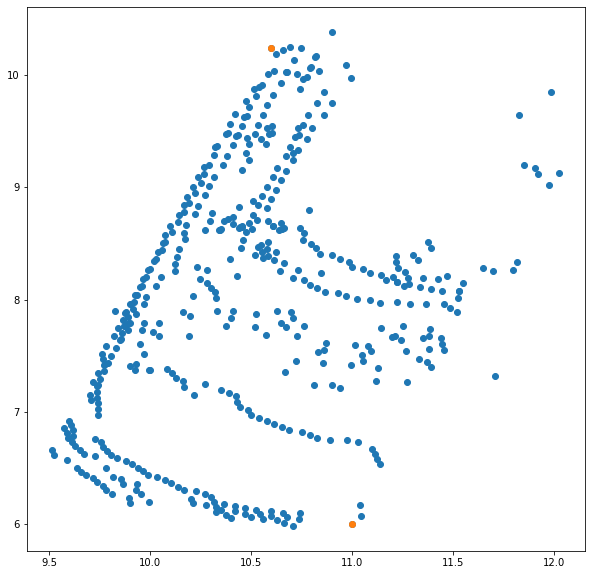

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(X,Y)
plt.scatter(X_re,Y_re)
plt.show()

In [55]:
X_re,Y_re =get_representative_point(refer_rows,refer_cols,Td_map)
X,Y =get_representative_point(rows,cols,Td_map)

In [13]:
draw(pcd,width=1000,height=1000)

NameError: name 'draw' is not defined

In [ ]:
Valid_ind = (td_freq_map[i] != 0)&(td_freq_map[i]<self.data_collector.thred_map[i]) # None zero index

In [10]:
def get_pcd_colored(Td_map,Labeling_map,Foreground_map):
    
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(Td_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = Td_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = Td_map[i] * np.sin(longitudes)
        Valid_ind = (Td_map[i] != 0)&(Foreground_map[i])
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels)
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    Colors = np.full((len(Labels),3),np.array([[153,153,153]])/256)
    unique_label = np.unique(Labels)
    for l in unique_label[1:]:
        Colors[Labels == l] = color_map[l%len(color_map)]

    pcd = op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    return pcd    

In [5]:
pcd = get_pcd_colored_specified(Td_map,Labeling_map,Specified_label = [3,4])

In [78]:
draw(pcd)

[Open3D INFO] Window window_6 created.


WebVisualizer(window_uid='window_6')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, st

[8843:983][4923] (webrtc_sdp.cc:420): Failed to parse: "". Reason: Expect line: candidate:<candidate-str>


[Open3D WARNING] Can't parse received candidate message.


In [53]:
unique_label = np.unique(Labeling_map)[1:]
boundary_cols = []
boundary_rows = []

for l in unique_label:
    rows,cols = np.where(Labeling_map == l)
    sorted_cols_ind = np.argsort(cols)
    sorted_cols = cols[sorted_cols_ind]
    sorted_rows = rows[sorted_cols_ind]
    left_col,right_col = sorted_cols[0],sorted_cols[-1]
    
    if (right_col - left_col) >  900:
        left_col += 1800 
    boundary_cols.append([left_col,right_col])
    boundary_rows.append([rows[sorted_cols_ind[0]],rows[sorted_cols_ind[-1]]])
boundary_cols,boundary_rows = np.array(boundary_cols),np.array(boundary_rows)

sorted_label = np.argsort(boundary_cols[:,0])
adjacent_label_pairs = []
for sl in range(len(sorted_label) - 1):
    if boundary_cols[sorted_label[sl],1] < boundary_cols[sorted_label[sl+1],0]:
        adjacent_label_pairs.append([sorted_label[sl],sorted_label[sl+1]])
        
if boundary_cols[sorted_label[-1],1] > 1800:
    if (boundary_cols[sorted_label[-1],1] - 1800) < boundary_cols[sorted_label[0],0]:
        adjacent_label_pairs.append([sorted_label[-1],sorted_label[0]])
else:
    if boundaries[sorted_label[-1],1] < boundaries[sorted_label[0],0]:
        adjacent_label_pairs.append([sorted_label[-1],sorted_label[0]])
merging_pairs = []
for adjacent in adjacent_label_pairs:
    pair_a,pair_b = adjacent[0],adjacent[1]
    interval_left_col,interval_right_col = boundary_cols[pair_a][1],boundary_cols[pair_b][0]
    interval_left_row,interval_right_row = boundary_rows[pair_a][1],boundary_rows[pair_b][0]
#     print(interval_left_col,interval_right_col)
    high = interval_left_row
    low = interval_right_row
    if high < low: 
        high,low = low,high
    
    interval_map = Td_map[low:high+1,interval_left_col:interval_right_col+1][Background_map[low:high+1,interval_left_col:interval_right_col+1]]
    min_dis_int = interval_map.min()
    min_dis_a = Td_map[Labeling_map == pair_a].min()
    min_dis_b = Td_map[Labeling_map == pair_b].min()
    if (min_dis_int<min_dis_a)&(min_dis_int<min_dis_b)&(np.abs(min_dis_a - min_dis_b) < 1.2):
        merging_pairs.append([pair_a,pair_b])